In [1]:
import os
import random
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import kaggle

In [2]:
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('omkargurav/face-mask-dataset',unzip=True)

In [3]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: []


In [4]:
with_mask = [(os.path.join('data/with_mask', i), "with_mask") for i in os.listdir('data/with_mask')]
without_mask = [(os.path.join('data/without_mask', i), "without_mask") for i in os.listdir('data/without_mask')]
images = random.sample(with_mask+without_mask,6)

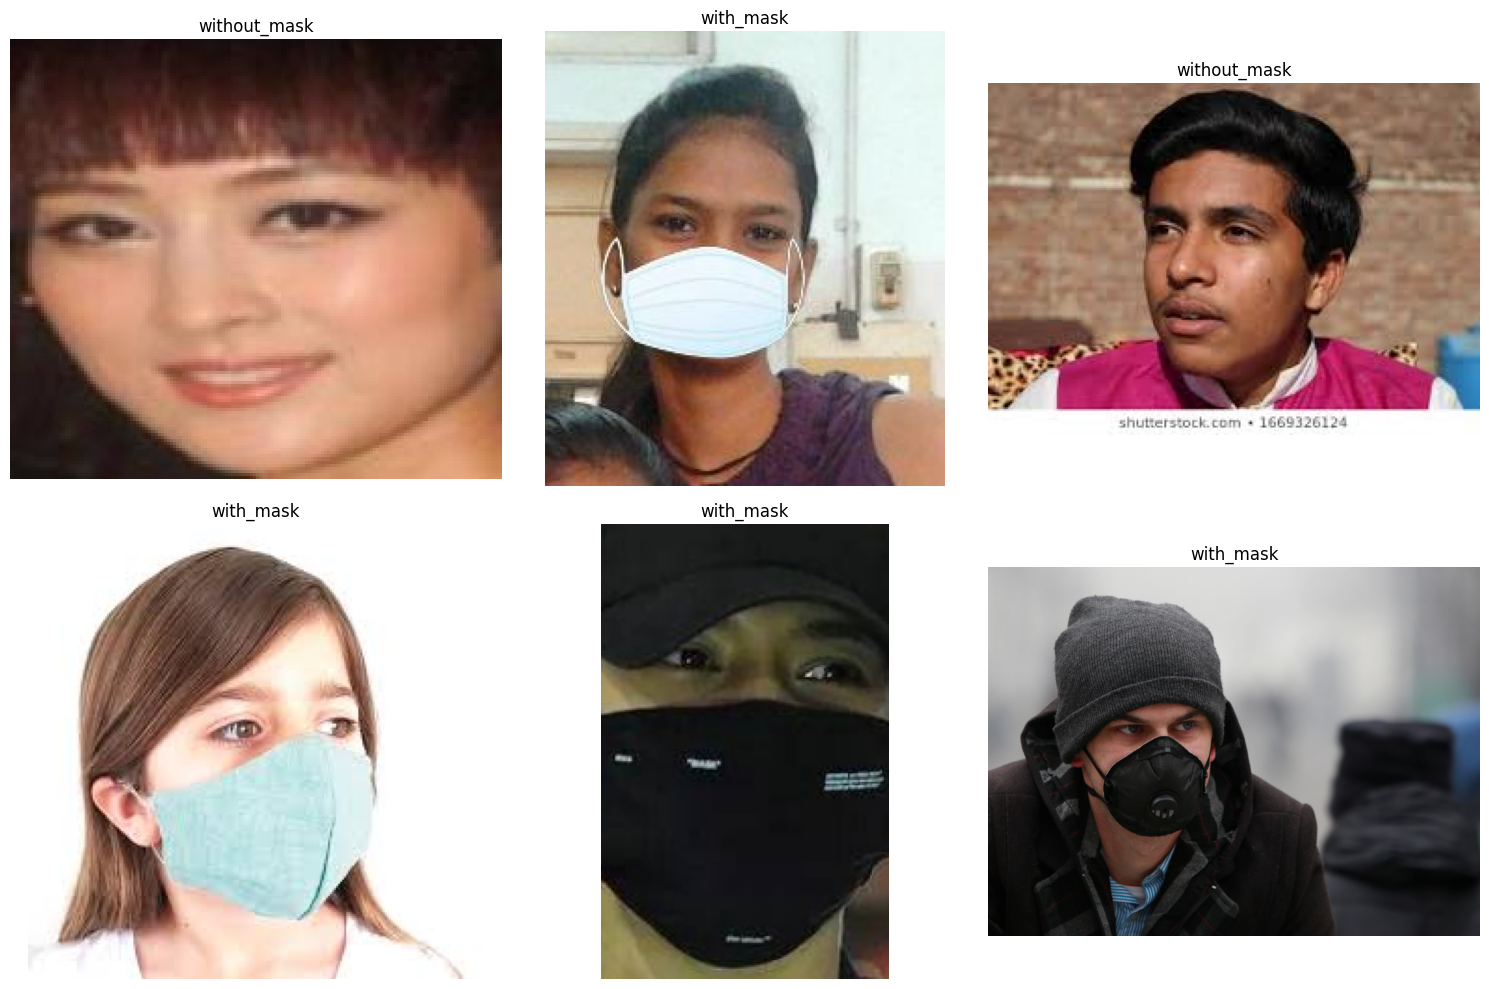

In [5]:
cols = 3
rows = int(np.ceil(len(images)/cols))

fig,ax = plt.subplots(rows,cols,figsize=(5*cols,5*rows))
ax = ax.flatten()

for i,(img_path,label) in enumerate(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(label)

    for j in range(i+1, len(ax)):
        ax[j].axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


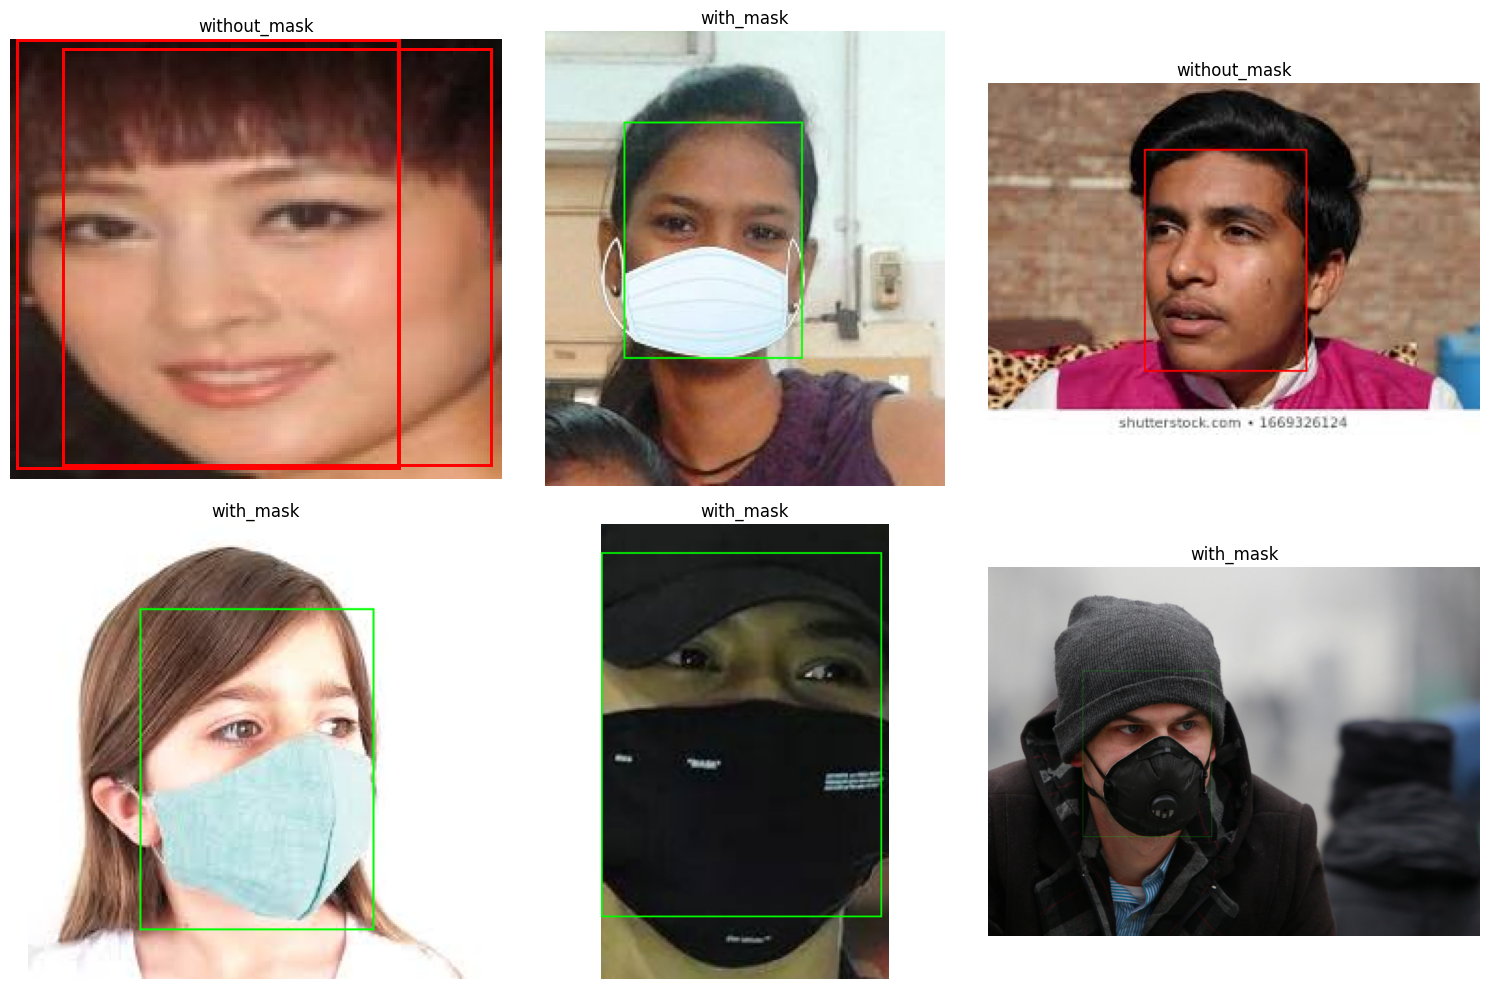

In [6]:
import detect
cols = 3
rows = int(np.ceil(len(images)/cols))

fig,ax = plt.subplots(rows,cols,figsize=(5*cols,5*rows))
ax = ax.flatten()

for i,(img_path,label) in enumerate(images):
    img = cv2.imread(img_path)
    annotated = detect.detect_and_annotate(img)
    img_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_rgb)
    ax[i].axis('off')
    ax[i].set_title(label)

    for j in range(i+1, len(ax)):
        ax[j].axis('off')
plt.tight_layout()
plt.show()


In [7]:
import detect
image_path = r"assets/test.png"
img = cv2.imread(image_path)
annotated = detect.detect_and_annotate(img)
cv2.namedWindow("Result", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Result", 1000, 800)
cv2.imshow("Result", annotated)

cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
